In [ ]:
pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 51.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=38bb4139b7d65bc35e40c867736ee4b36bc72ef71d66180d60ef2f0dce4de2fd
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [11]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pyspark
from pyspark.sql.types import DateType,IntegerType, FloatType
from pyspark.sql.functions import col,lower,regexp_replace,when
from pyspark.ml.feature import CountVectorizer,Tokenizer,IDF,StopWordsRemover
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

# 1. Small dataset

In [27]:
spark = SparkSession.builder.appName('split').getOrCreate()

data_small = spark.read.csv('ratings_small.csv', header=True, schema='userId INT, movieId INT, rating FLOAT, timestamp INT')
data_small.write.parquet('data/data_small.parquet', mode="overwrite")

pq_data_small = spark.read.parquet('data/data_small.parquet')
pq_data_small.createOrReplaceTempView('pq_data_small')
total_users = pq_data_small.select('userId').distinct()

### Remove movies that have less that 10 ratings.
table_1 = spark.sql("SELECT * FROM pq_data_small WHERE movieId IN (SELECT movieId FROM pq_data_small GROUP BY movieId HAVING COUNT(rating) > 50 )")
table_1.createOrReplaceTempView('table_1')

### Remove users thtat have less thant 10 rated movies.
table_2 = spark.sql("SELECT * FROM table_1 WHERE userId IN (SELECT userId FROM table_1 GROUP BY userId HAVING COUNT(rating) > 50 )")
table_2.select('table_1.userId', 'table_1.movieId', 'table_1.rating') ### eliminate timestamp which we will not use in this project
table_2.createOrReplaceTempView('table_2')


### Subsampling with 5% users.
users_d = total_users.sample(False, 0.05)
table_3 = users_d.join(table_2, on=['userId'], how='left')
table_4 = table_3.filter(F.col('rating').isNotNull())
table_4.createOrReplaceTempView('table_4')

### Data spliting
train_id, val_id, test_id = [i.rdd.flatMap(lambda x: x).collect() for i in table_4.select('userId').distinct().randomSplit([0.6, 0.2, 0.2], 1004)]
train = pq_data_small.where(pq_data_small.userId.isin(train_id))
val = pq_data_small.where(pq_data_small.userId.isin(val_id))
test = pq_data_small.where(pq_data_small.userId.isin(test_id))

train_table = train.filter(F.col('rating').isNotNull())
val_table = val.filter(F.col('rating').isNotNull())
test_table = test.filter(F.col('rating').isNotNull())

### Filter val and test set to train set by half and check it the movieId exist in train set.
val_temp = val_table.select("userId","movieId","rating",'timestamp', F.row_number().over(Window.partitionBy("userId").orderBy("movieId")).alias("row_Num"))
test_temp = test_table.select("userId","movieId","rating",'timestamp', F.row_number().over(Window.partitionBy("userId").orderBy("movieId")).alias("row_Num"))

val_temp.createOrReplaceTempView('val_temp')
test_temp.createOrReplaceTempView('test_temp')

val_merge = spark.sql('SELECT userId, movieId, rating, timestamp FROM val_temp WHERE row_Num % 2 == 0')
val_keep = spark.sql('SELECT userId, movieId, rating, timestamp FROM val_temp WHERE row_Num % 2 != 0')
test_merge = spark.sql('SELECT userId, movieId, rating, timestamp FROM test_temp WHERE row_Num % 2 == 0')
test_keep = spark.sql('SELECT userId, movieId, rating, timestamp FROM test_temp WHERE row_Num % 2 != 0')

train_filtered = train_table.union(val_merge).union(test_merge)
train_filtered.createOrReplaceTempView('train_filtered')

### Writing splitted files to parquet files in data folder. 
train_filtered.write.parquet('data/small_train.parquet', mode="overwrite")
val_keep.write.parquet('data/small_val.parquet', mode="overwrite")
test_keep.write.parquet('data/small_test.parquet', mode="overwrite")

In [28]:
small_train = spark.read.parquet('data/small_train.parquet')
spark.sparkContext.setCheckpointDir('checkpoint')

iter = 30
reg = 1e-5
rank = 5

als = ALS().setMaxIter(iter).setRegParam(reg).setRank(rank).setUserCol("userId").setItemCol("movieId").setRatingCol("rating")
model = als.fit(small_train)

item_factors_small = model.itemFactors
item_factors_small_df = item_factors_small.toPandas()
item_factors_small_df
#item_factors_df.columns = ['movieId','latent']

item_matrix_small = []
for feature in item_factors_small_df['features']:
  item_matrix_small.append(feature)

item_matrix_small = pd.DataFrame(item_matrix_small)
item_matrix_small['id'] = item_factors_small_df['id']

small_train_df = small_train.toPandas()

sorted_matrix_small = item_matrix_small.sort_values(by=['id'])
sorted_matrix_small['average_rating'] = list(small_train_df.groupby('movieId').mean().rating)
sorted_matrix_small['round_rating'] = round(sorted_matrix_small.average_rating)
sorted_matrix_small

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,0,1,2,3,4,id,average_rating,round_rating
116,-3.239427,6.319962,0.956134,-2.800429,1.456766,1,4.333333,4.0
226,56.309734,-11.257242,-49.456234,69.862358,2.234535,2,3.750000,4.0
355,2.546079,2.749328,0.472532,-0.216440,3.023066,3,2.250000,2.0
606,0.600969,2.884846,4.215123,2.979959,1.883301,5,4.000000,4.0
721,3.468167,1.510600,1.958682,-4.490427,6.929768,6,2.000000,2.0
...,...,...,...,...,...,...,...,...
720,-2.160454,2.067057,0.217355,2.401495,1.894420,140715,4.500000,4.0
1114,-1.607739,-0.485665,0.900183,-2.630599,0.140523,142488,5.000000,5.0
836,-2.400504,2.296730,0.241506,2.668328,2.104911,148626,5.000000,5.0
225,-1.286191,-0.388532,0.720147,-2.104479,0.112418,152081,4.000000,4.0


## 1.1 TSNE

In [29]:
features_small = sorted_matrix_small[np.arange(5)].values
standard_features_small = StandardScaler().fit_transform(features_small)
TSNE_embedded_small = TSNE(n_components=2, verbose=1, n_iter=500, learning_rate='auto', init='random').fit_transform(standard_features_small)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1245 samples in 0.002s...
[t-SNE] Computed neighbors for 1245 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1245
[t-SNE] Computed conditional probabilities for sample 1245 / 1245
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.832924
[t-SNE] KL divergence after 500 iterations: 0.344148


Text(0.5, 1.0, 'TSNE of rounded average rating of movieId of small dataset')

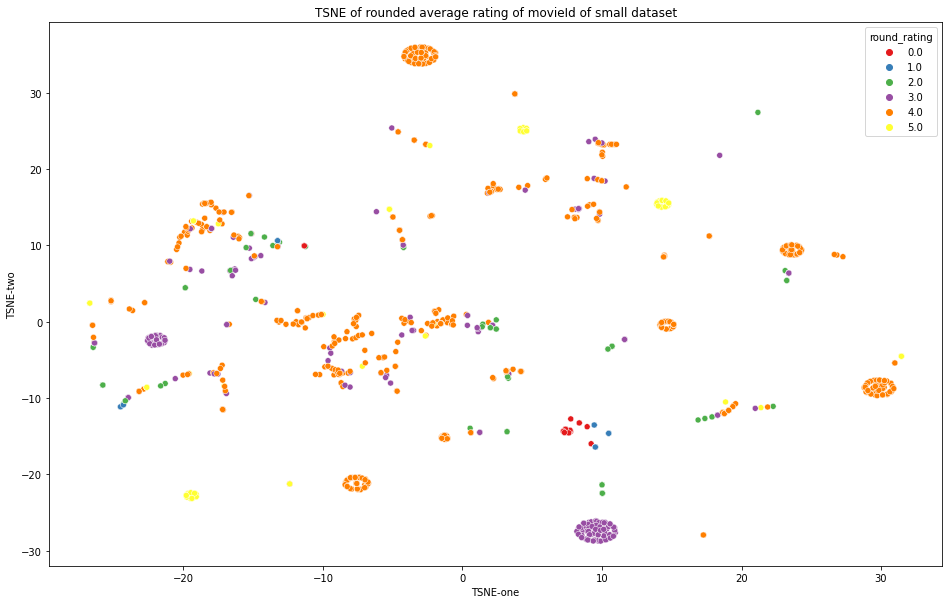

In [45]:
sorted_matrix_small['TSNE-one'] = TSNE_embedded_small[:,0]
sorted_matrix_small['TSNE-two'] = TSNE_embedded_small[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(x="TSNE-one", y="TSNE-two", hue="round_rating", palette=sns.color_palette("Set1", 6), data=sorted_matrix_small, alpha=1)
plt.title('TSNE of rounded average rating of movieId of small dataset')

## 1.2 PCA

In [31]:
pca_small = PCA(n_components=2)
pca_embedding_small = pca_small.fit_transform(standard_features_small)
print(pca_small.explained_variance_ratio_)

[0.30395231 0.25790238]


Text(0.5, 1.0, 'PCA of rounded average rating of movieId of small dataset')

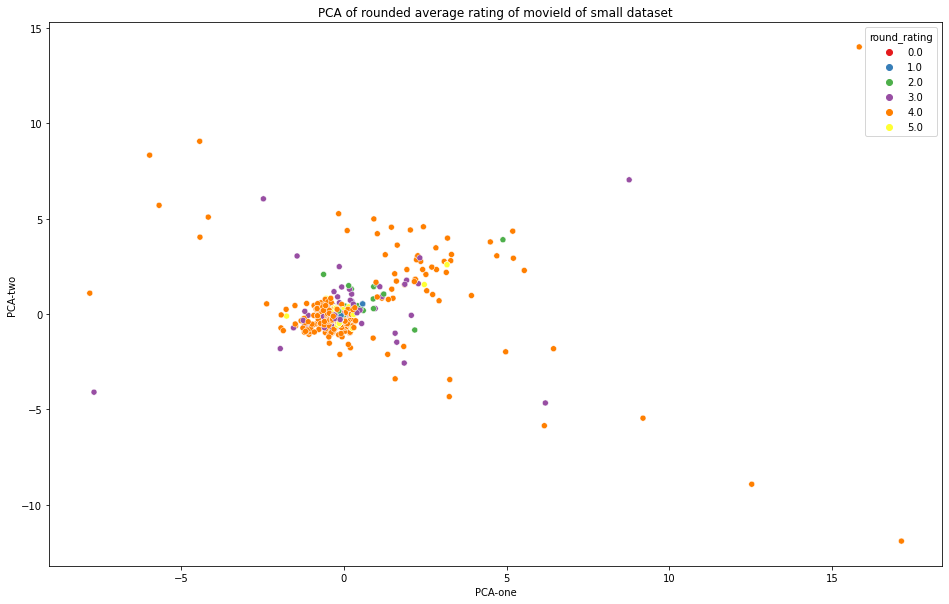

In [46]:
sorted_matrix_small['PCA-one'] = pca_embedding_small[:,0]
sorted_matrix_small['PCA-two'] = pca_embedding_small[:,1] 

plt.figure(figsize=(16,10))
sns.scatterplot(x="PCA-one", y="PCA-two", hue="round_rating", 
                palette=sns.color_palette("Set1", 6), data=sorted_matrix_small, alpha=1)
plt.title('PCA of rounded average rating of movieId of small dataset')

# 2. Large Dataset

In [38]:
spark = SparkSession.builder.appName('split').getOrCreate()

data_large = spark.read.csv('ratings_large.csv', header=True, schema='userId INT, movieId INT, rating FLOAT, timestamp INT')
data_large.write.parquet('data/data_large.parquet', mode="overwrite")

pq_data_large = spark.read.parquet('data/data_large.parquet')
pq_data_large.createOrReplaceTempView('pq_data_large')
total_users = pq_data_large.select('userId').distinct()

### Remove movies that have less that 10 ratings.
table_1 = spark.sql("SELECT * FROM pq_data_large WHERE movieId IN (SELECT movieId FROM pq_data_large GROUP BY movieId HAVING COUNT(rating) > 50 )")
table_1.createOrReplaceTempView('table_1')

### Remove users thtat have less thant 10 rated movies.
table_2 = spark.sql("SELECT * FROM table_1 WHERE userId IN (SELECT userId FROM table_1 GROUP BY userId HAVING COUNT(rating) > 50 )")
table_2.select('table_1.userId', 'table_1.movieId', 'table_1.rating') ### eliminate timestamp which we will not use in this project
table_2.createOrReplaceTempView('table_2')


### Subsampling with 5% users.
users_d = total_users.sample(False, 0.05)
table_3 = users_d.join(table_2, on=['userId'], how='left')
table_4 = table_3.filter(F.col('rating').isNotNull())
table_4.createOrReplaceTempView('table_4')

### Data spliting.
train_id, val_id, test_id = [i.rdd.flatMap(lambda x: x).collect() for i in table_4.select('userId').distinct().randomSplit([0.6, 0.2, 0.2], 1004)]
train = pq_data_large.where(pq_data_large.userId.isin(train_id))
val = pq_data_large.where(pq_data_large.userId.isin(val_id))
test = pq_data_large.where(pq_data_large.userId.isin(test_id))

train_table = train.filter(F.col('rating').isNotNull())
val_table = val.filter(F.col('rating').isNotNull())
test_table = test.filter(F.col('rating').isNotNull())

### Filter val and test set to train set by half and check it the movieId exist in train set.
val_temp = val_table.select("userId","movieId","rating",'timestamp', F.row_number().over(Window.partitionBy("userId").orderBy("movieId")).alias("row_Num"))
test_temp = test_table.select("userId","movieId","rating",'timestamp', F.row_number().over(Window.partitionBy("userId").orderBy("movieId")).alias("row_Num"))

val_temp.createOrReplaceTempView('val_temp')
test_temp.createOrReplaceTempView('test_temp')

val_merge = spark.sql('SELECT userId, movieId, rating, timestamp FROM val_temp WHERE row_Num % 2 == 0')
val_keep = spark.sql('SELECT userId, movieId, rating, timestamp FROM val_temp WHERE row_Num % 2 != 0')
test_merge = spark.sql('SELECT userId, movieId, rating, timestamp FROM test_temp WHERE row_Num % 2 == 0')
test_keep = spark.sql('SELECT userId, movieId, rating, timestamp FROM test_temp WHERE row_Num % 2 != 0')

train_filtered = train_table.union(val_merge).union(test_merge)
train_filtered.createOrReplaceTempView('train_filtered')

val_keep.createOrReplaceTempView('val_keep')
test_keep.createOrReplaceTempView('test_keep')

val_filtered = spark.sql('SELECT * FROM val_keep WHERE movieId IN (SELECT DISTINCT movieId FROM train_filtered)')
test_filtered = spark.sql('SELECT * FROM test_keep WHERE movieId IN (SELECT DISTINCT movieId FROM train_filtered)')

### Writing splitted files to parquet files in data folder. 
train_filtered.write.parquet('data/large_train.parquet', mode="overwrite")
val_filtered.write.parquet('data/large_val.parquet', mode="overwrite")
test_filtered.write.parquet('data/large_test.parquet', mode="overwrite")

In [49]:
large_train = spark.read.parquet('data/large_train.parquet')
spark.sparkContext.setCheckpointDir('checkpoint')

iter = 30
reg = 1e-2
rank = 50

als = ALS().setMaxIter(iter).setRegParam(reg).setRank(rank).setUserCol("userId").setItemCol("movieId").setRatingCol("rating")
model = als.fit(large_train)

item_factors_large = model.itemFactors
item_factors_large_df = item_factors_large.toPandas()
item_factors_large_df
#item_factors_df.columns = ['movieId','latent']

item_matrix_large = []
for feature in item_factors_large_df['features']:
  item_matrix_large.append(feature)

item_matrix_large = pd.DataFrame(item_matrix_large)
item_matrix_large['id'] = item_factors_large_df['id']

large_train_df = large_train.toPandas()

sorted_matrix_large = item_matrix_large.sort_values(by=['id'])
sorted_matrix_large['average_rating'] = list(large_train_df.groupby('movieId').mean().rating)
sorted_matrix_large['round_rating'] = round(sorted_matrix_large.average_rating)
sorted_matrix_large

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,id,average_rating,round_rating
2144,0.359348,-0.555441,-0.145703,0.631420,0.093145,0.372955,-1.017084,0.095200,0.466491,-0.204486,...,-0.052055,0.579271,0.086575,-0.063577,-0.548157,0.050436,0.322829,1,3.872710,4.0
4248,0.445312,0.090273,0.594733,0.506785,0.219908,0.209588,-0.267374,-0.087032,-0.422920,-0.021201,...,0.203493,0.103994,0.086481,-0.201243,-0.408021,0.045926,0.103480,2,3.195297,3.0
6367,0.300808,-0.214250,0.527545,-0.159816,0.652595,-0.125103,-0.207339,0.599539,0.779476,-0.472777,...,-0.353190,-0.322423,-0.328332,-0.352682,-0.674473,-0.377241,0.447414,3,3.112532,3.0
8465,-0.067379,0.465067,0.241289,0.288974,0.426626,-0.123204,-1.133130,-0.028864,-0.108916,-0.460559,...,-0.612329,-0.032392,0.391646,0.357386,-0.994712,0.169671,0.187252,4,2.662921,3.0
10561,0.368285,-0.185830,0.419349,0.084714,-0.447664,0.384704,-0.900833,-0.436073,0.210122,0.231264,...,0.132129,-0.259041,0.188205,0.113213,-0.093133,0.277626,-0.209188,5,2.933803,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,0.099753,-0.154795,-0.046142,-0.089045,-0.203689,-0.155784,-0.369932,0.264842,-0.127311,0.085432,...,-0.045260,0.062244,0.098202,-0.033286,-0.285230,0.166484,-0.114144,193243,2.250000,2.0
12671,0.104473,0.024817,0.221965,0.157738,-0.096910,-0.067163,-0.017186,-0.031641,-0.030416,-0.016337,...,0.088131,0.060995,0.062103,-0.003810,-0.109594,-0.100936,-0.110313,193465,2.000000,2.0
12672,0.051507,-0.039688,0.130848,0.104622,-0.060660,0.070626,-0.057035,0.043407,0.010801,0.003701,...,-0.052051,0.061093,0.046729,0.067000,-0.090460,-0.007733,-0.047280,193695,1.000000,1.0
12673,0.249617,-0.105980,-0.122138,0.181326,-0.353071,0.126506,-0.184472,-0.178447,-0.236769,-0.183528,...,-0.332469,0.082749,0.286942,0.287670,-0.026026,-0.309888,0.165536,193855,3.500000,4.0


## 2.1 TSNE

In [51]:
features_large = sorted_matrix_large[np.arange(50)].values
standard_features_large = StandardScaler().fit_transform(features_large)
TSNE_embedded_large = TSNE(n_components=2, verbose=1, n_iter=500, learning_rate='auto', init='random').fit_transform(standard_features_large)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 21074 samples in 0.001s...
[t-SNE] Computed neighbors for 21074 samples in 13.689s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21074
[t-SNE] Computed conditional probabilities for sample 2000 / 21074
[t-SNE] Computed conditional probabilities for sample 3000 / 21074
[t-SNE] Computed conditional probabilities for sample 4000 / 21074
[t-SNE] Computed conditional probabilities for sample 5000 / 21074
[t-SNE] Computed conditional probabilities for sample 6000 / 21074
[t-SNE] Computed conditional probabilities for sample 7000 / 21074
[t-SNE] Computed conditional probabilities for sample 8000 / 21074
[t-SNE] Computed conditional probabilities for sample 9000 / 21074
[t-SNE] Computed conditional probabilities for sample 10000 / 21074
[t-SNE] Computed conditional probabilities for sample 11000 / 21074
[t-SNE] Computed conditional probabilities for sample 12000 / 21074
[t-SNE] Computed conditional probabilities for sa

Text(0.5, 1.0, 'TSNE of rounded average rating of movieId of large dataset')

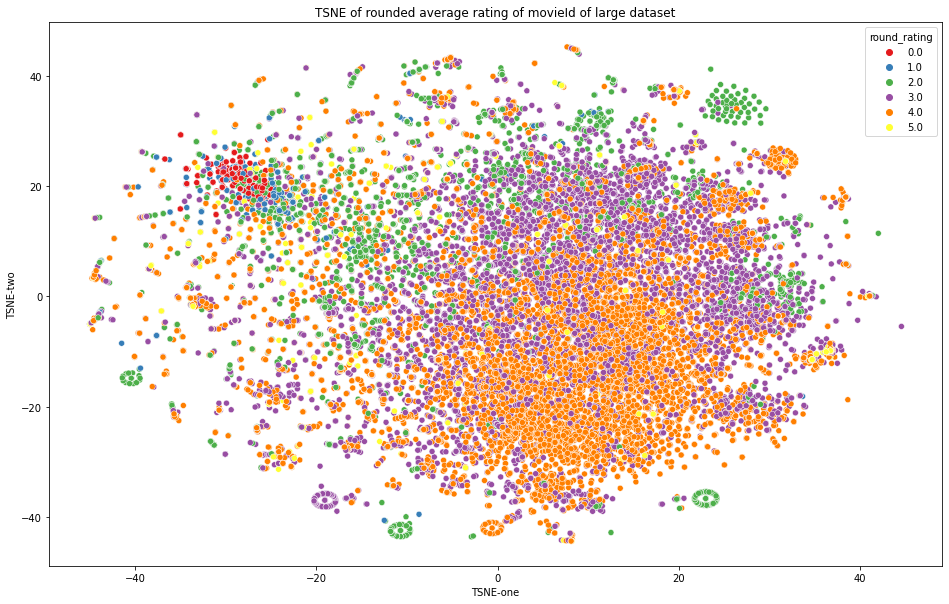

In [52]:
sorted_matrix_large['TSNE-one'] = TSNE_embedded_large[:,0]
sorted_matrix_large['TSNE-two'] = TSNE_embedded_large[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(x="TSNE-one", y="TSNE-two", hue="round_rating", 
                palette=sns.color_palette("Set1", 6), data=sorted_matrix_large, alpha=1)
plt.title('TSNE of rounded average rating of movieId of large dataset')


## 2.2 PCA

In [53]:
pca_large = PCA(n_components=2)
pca_embedding_large = pca_large.fit_transform(standard_features_large)
print(pca_large.explained_variance_ratio_)

[0.11917037 0.06671155]


Text(0.5, 1.0, 'PCA of rounded average rating of movieId of large dataset')

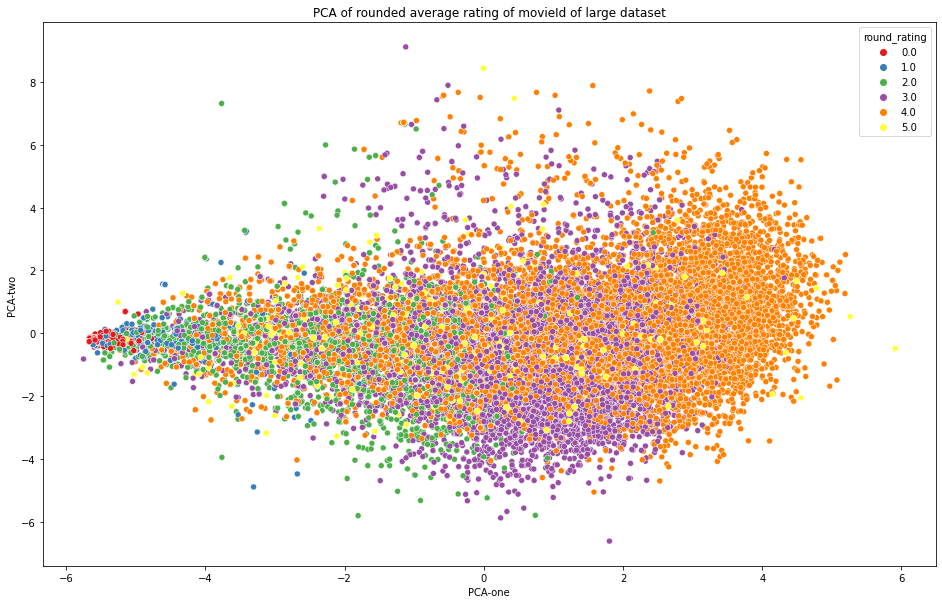

In [54]:
sorted_matrix_large['PCA-one'] = pca_embedding_large[:,0]
sorted_matrix_large['PCA-two'] = pca_embedding_large[:,1] 

plt.figure(figsize=(16,10))
sns.scatterplot(x="PCA-one", y="PCA-two", hue="round_rating", 
                palette=sns.color_palette("Set1", 6), data=sorted_matrix_large, alpha=1)
plt.title('PCA of rounded average rating of movieId of large dataset')